In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from pathlib import Path

print("Анализ производительности по типам атак")
print("="*60)

# Загрузка тестовых данных
X_normalized = pd.read_parquet('../data/processed/X_normalized.parquet')
y_multiclass = pd.read_parquet('../data/processed/y_multiclass.parquet')['attack_cat']

# Загрузка многоклассовой модели
multiclass_package = joblib.load('../models/best_multiclass_classifier.joblib')
multiclass_model = multiclass_package['model']
label_encoder = multiclass_package['label_encoder']

print(f"Модель загружена: {type(multiclass_model).__name__}")
print(f"Типы атак: {list(label_encoder.classes_)}")
# Разделение данных (используем то же разделение, что и при обучении)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_multiclass, 
    test_size=0.2, 
    random_state=42,
    stratify=y_multiclass
)

# Кодируем метки
y_test_encoded = label_encoder.transform(y_test)

# Получаем предсказания
print("\nПолучение предсказаний модели...")
y_pred = multiclass_model.predict(X_test)
y_pred_proba = multiclass_model.predict_proba(X_test) if hasattr(multiclass_model, "predict_proba") else None

print(f"Предсказания получены")
print(f"Тестовая выборка: {len(y_test)} записей")

Анализ производительности по типам атак
Модель загружена: XGBClassifier
Типы атак: ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']

Получение предсказаний модели...
Предсказания получены
Тестовая выборка: 51535 записей


In [2]:
# Функция для детального анализа по классам
def detailed_attack_analysis(y_true, y_pred, label_encoder):
    
    y_true_decoded = label_encoder.inverse_transform(y_true)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    
    # Получаем метрики для каждого класса
    classes = label_encoder.classes_
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_decoded, y_pred_decoded, labels=classes, zero_division=0
    )
    
    # Создаем DataFrame с метриками
    performance_df = pd.DataFrame({
        'Attack_Type': classes,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Support': support
    })
    
    # Добавляем дополнительные метрики
    performance_df['Accuracy'] = [
        np.mean(y_true_decoded[y_true_decoded == attack_type] == y_pred_decoded[y_true_decoded == attack_type])
        for attack_type in classes
    ]
    
    # Сортируем по F1-score
    performance_df = performance_df.sort_values('F1_Score', ascending=False)
    
    return performance_df

# Запускаем анализ
print("\nЗапускаем анализ")
performance_df = detailed_attack_analysis(y_test_encoded, y_pred, label_encoder)

print("Производительность по типам атак (отсортировано по F1-Score):")
print(performance_df.round(4))


Запускаем анализ
Производительность по типам атак (отсортировано по F1-Score):
      Attack_Type  Precision  Recall  F1_Score  Support  Accuracy
5         Generic     0.9946  0.9811    0.9878    11774    0.9811
6          Normal     0.8750  0.9432    0.9078    18600    0.9432
7  Reconnaissance     0.9220  0.7777    0.8437     2798    0.7777
3        Exploits     0.6133  0.9209    0.7362     8905    0.9209
4         Fuzzers     0.6863  0.4820    0.5663     4849    0.4820
8       Shellcode     0.5058  0.5728    0.5373      302    0.5728
9           Worms     0.3462  0.2571    0.2951       35    0.2571
1        Backdoor     0.9200  0.0987    0.1783      466    0.0987
0        Analysis     0.9184  0.0841    0.1541      535    0.0841
2             DoS     0.6667  0.0544    0.1006     3271    0.0544



Визуализация метрик по типам атак


C:\Users\ro517\AppData\Local\Temp\ipykernel_12112\999638875.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_df, x='F1_Score', y='Attack_Type', palette='viridis')


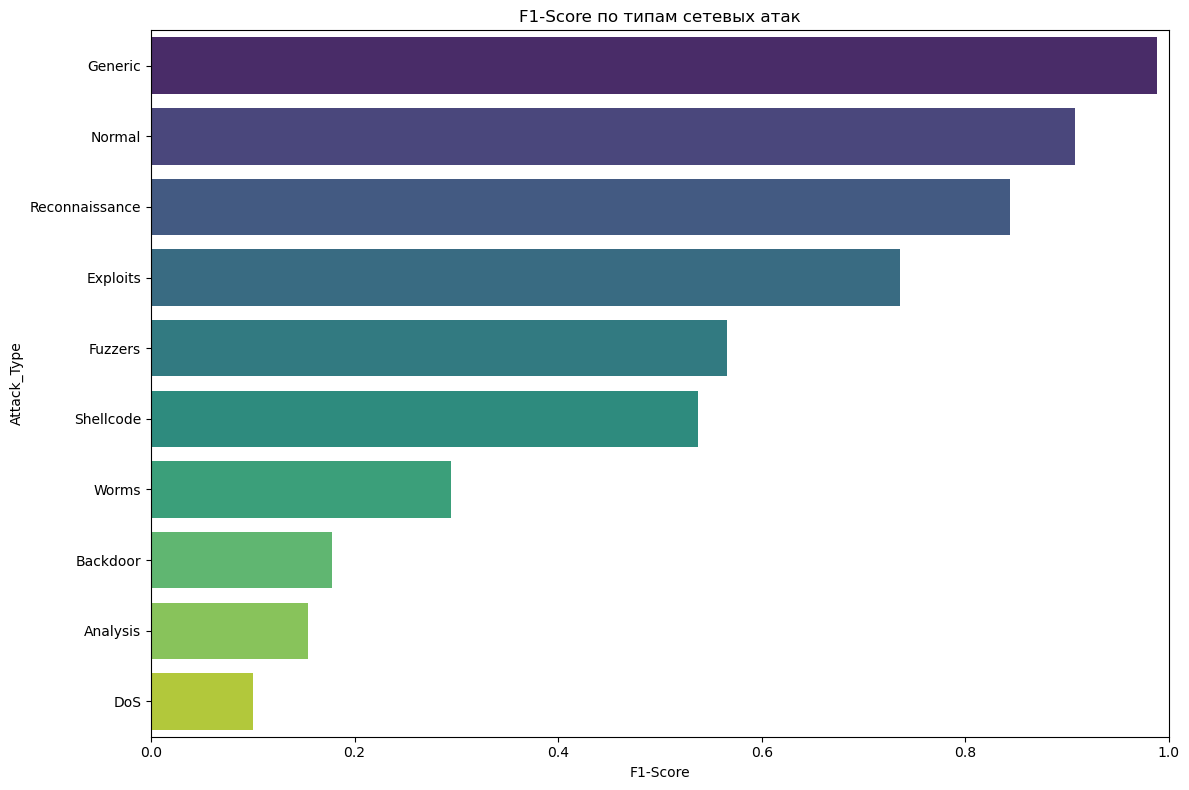

C:\Users\ro517\AppData\Local\Temp\ipykernel_12112\999638875.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_df, x='Precision', y='Attack_Type', ax=ax1, palette='Blues_d')
C:\Users\ro517\AppData\Local\Temp\ipykernel_12112\999638875.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_df, x='Recall', y='Attack_Type', ax=ax2, palette='Reds_d')


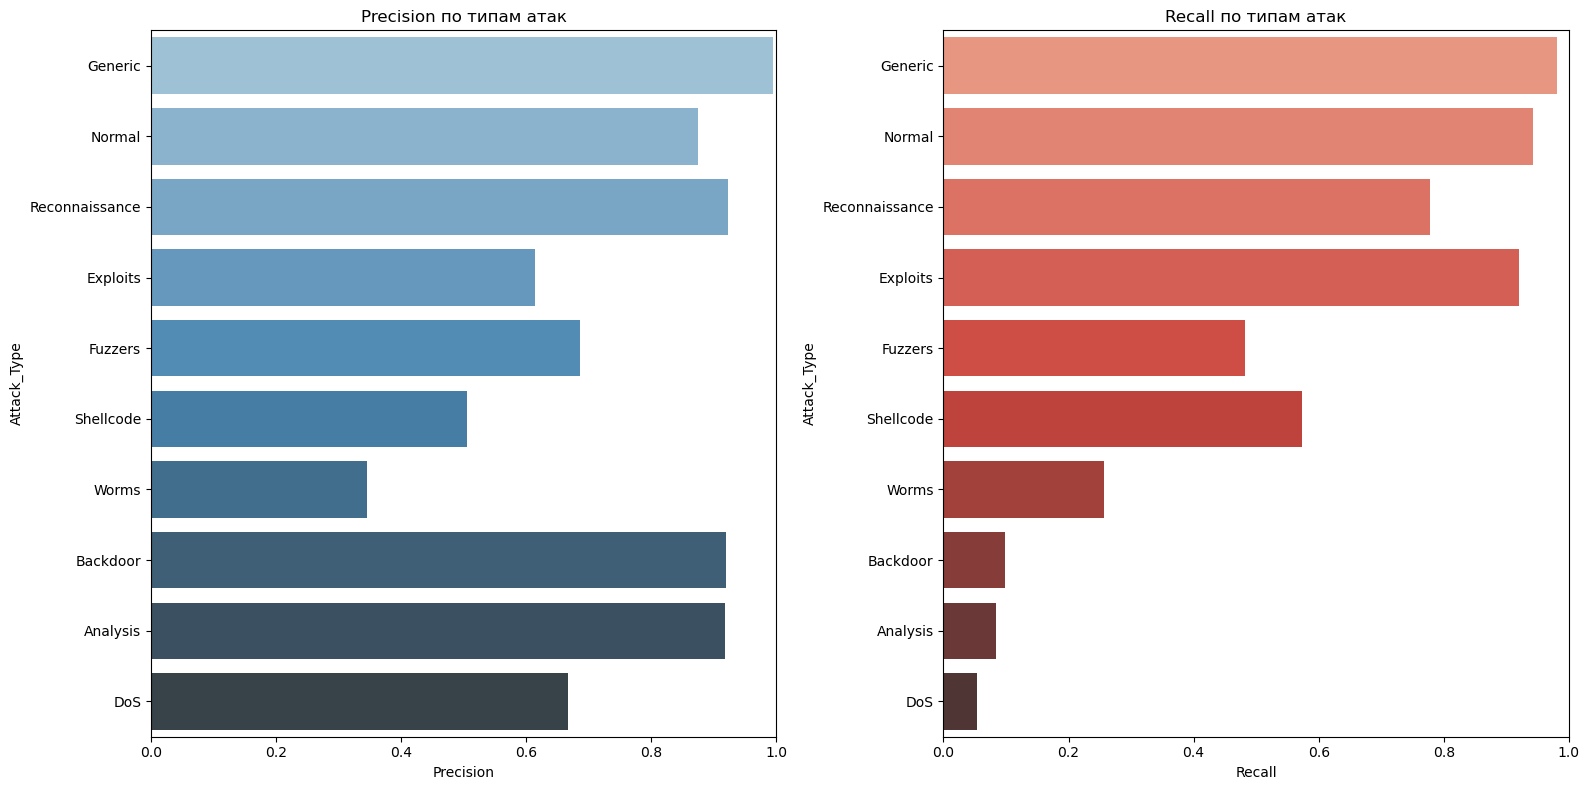

In [3]:
print("\nВизуализация метрик по типам атак")

# Создаем папку для графиков
reports_path = Path("../reports/figures")
reports_path.mkdir(parents=True, exist_ok=True)

# График F1-Score по типам атак
plt.figure(figsize=(12, 8))
sns.barplot(data=performance_df, x='F1_Score', y='Attack_Type', palette='viridis')
plt.title('F1-Score по типам сетевых атак')
plt.xlabel('F1-Score')
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(reports_path / 'f1_score_by_attack_type.png', dpi=300, bbox_inches='tight')
plt.show()

# Сравнение Precision и Recall
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Precision
sns.barplot(data=performance_df, x='Precision', y='Attack_Type', ax=ax1, palette='Blues_d')
ax1.set_title('Precision по типам атак')
ax1.set_xlim(0, 1)

# Recall
sns.barplot(data=performance_df, x='Recall', y='Attack_Type', ax=ax2, palette='Reds_d')
ax2.set_title('Recall по типам атак')
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(reports_path / 'precision_recall_by_attack_type.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Анализ атак с низкой производительностью
def analyze_problematic_attacks(performance_df, threshold=0.7):
    
    low_performance = performance_df[
        (performance_df['F1_Score'] < threshold) | 
        (performance_df['Precision'] < threshold) | 
        (performance_df['Recall'] < threshold)
    ]
    
    if len(low_performance) > 0:
        print(f"\nПРОБЛЕМНЫЕ ТИПЫ АТАК (F1 < {threshold}):")
        for _, row in low_performance.iterrows():
            print(f"   - {row['Attack_Type']}: F1={row['F1_Score']:.3f}, "
                  f"Precision={row['Precision']:.3f}, Recall={row['Recall']:.3f}, "
                  f"Примеров={row['Support']}")
        
        # Рекомендации по улучшению
        print(f"\nРЕКОМЕНДАЦИИ:")
        for _, row in low_performance.iterrows():
            if row['Support'] < 100:
                print(f"   - {row['Attack_Type']}: мало данных ({row['Support']} примеров) → сбор больше данных")
            elif row['Precision'] < row['Recall']:
                print(f"   - {row['Attack_Type']}: низкая Precision → много ложных срабатываний")
            else:
                print(f"   - {row['Attack_Type']}: низкая Recall → много пропущенных атак")
    else:
        print(f"Все типы атак имеют F1-Score >= {threshold}")
    
    return low_performance

# Запускаем анализ проблемных атак
problematic_attacks = analyze_problematic_attacks(performance_df, threshold=0.7)


ПРОБЛЕМНЫЕ ТИПЫ АТАК (F1 < 0.7):
   - Exploits: F1=0.736, Precision=0.613, Recall=0.921, Примеров=8905
   - Fuzzers: F1=0.566, Precision=0.686, Recall=0.482, Примеров=4849
   - Shellcode: F1=0.537, Precision=0.506, Recall=0.573, Примеров=302
   - Worms: F1=0.295, Precision=0.346, Recall=0.257, Примеров=35
   - Backdoor: F1=0.178, Precision=0.920, Recall=0.099, Примеров=466
   - Analysis: F1=0.154, Precision=0.918, Recall=0.084, Примеров=535
   - DoS: F1=0.101, Precision=0.667, Recall=0.054, Примеров=3271

РЕКОМЕНДАЦИИ:
   - Exploits: низкая Precision → много ложных срабатываний
   - Fuzzers: низкая Recall → много пропущенных атак
   - Shellcode: низкая Precision → много ложных срабатываний
   - Worms: мало данных (35 примеров) → сбор больше данных
   - Backdoor: низкая Recall → много пропущенных атак
   - Analysis: низкая Recall → много пропущенных атак
   - DoS: низкая Recall → много пропущенных атак


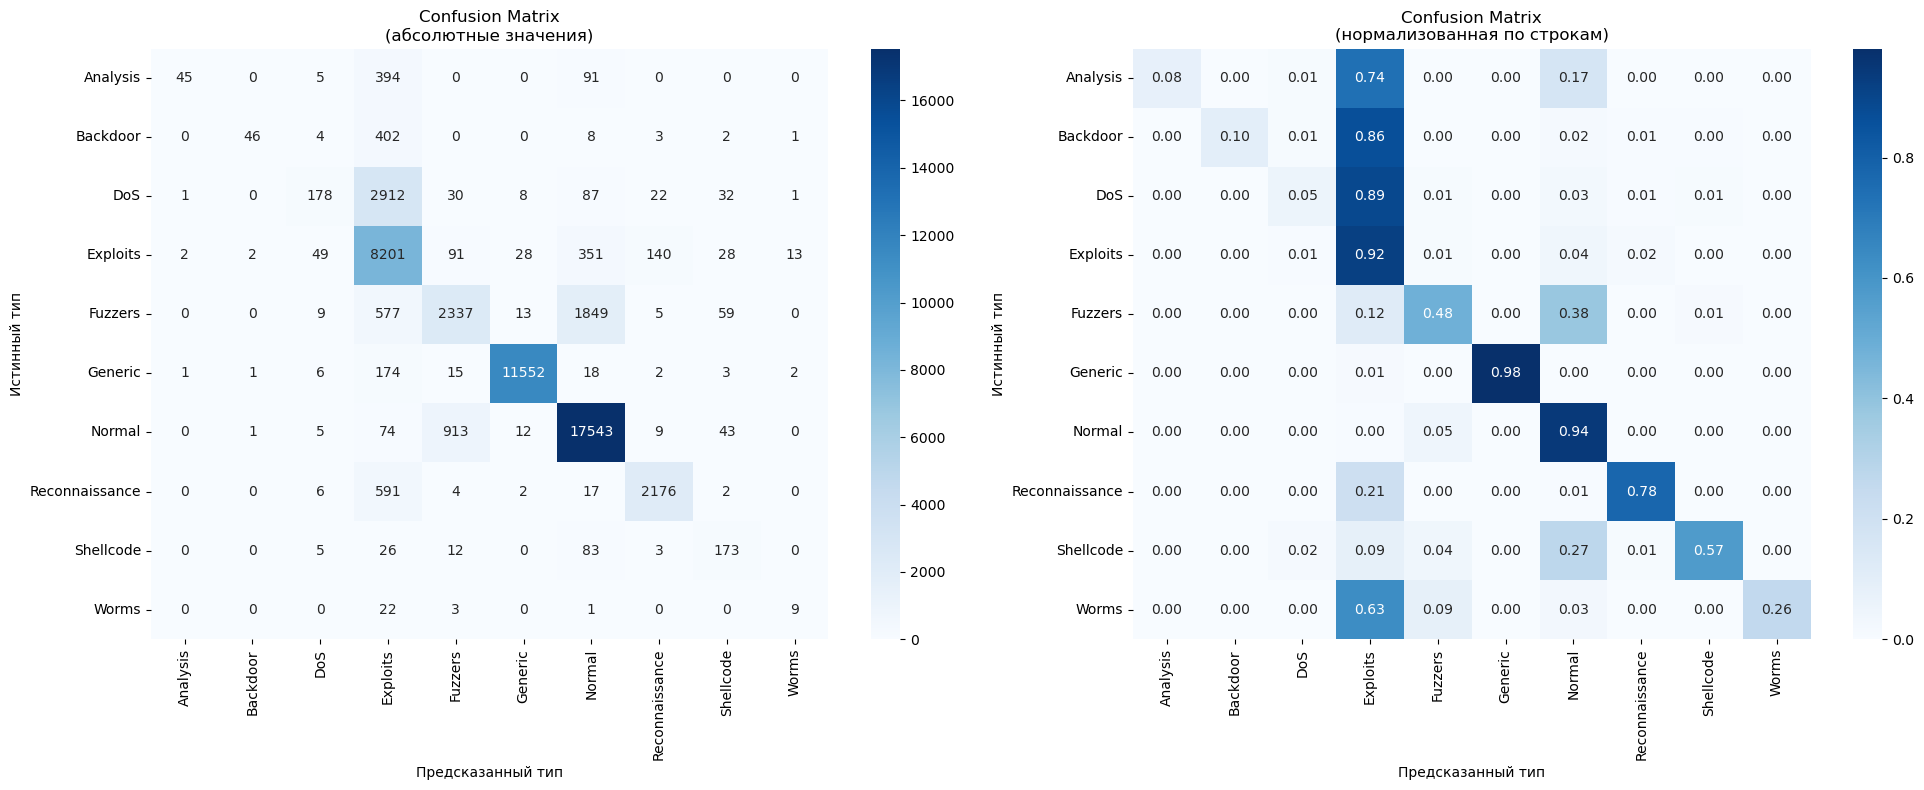

In [5]:
# Создаем confusion matrix
y_true_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

cm = confusion_matrix(y_true_decoded, y_pred_decoded, labels=label_encoder.classes_)

# Нормализованная confusion matrix (по строкам)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Стандартная confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
ax1.set_title('Confusion Matrix\n(абсолютные значения)')
ax1.set_xlabel('Предсказанный тип')
ax1.set_ylabel('Истинный тип')

# Нормализованная confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
ax2.set_title('Confusion Matrix\n(нормализованная по строкам)')
ax2.set_xlabel('Предсказанный тип')
ax2.set_ylabel('Истинный тип')

plt.tight_layout()
plt.savefig(reports_path / 'detailed_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Сравнение многоклассовой и бинарной классификации
def compare_with_binary_classification():
    
    # Загрузка бинарной модели
    binary_model = joblib.load('../models/best_binary_classifier.joblib')
    y_binary = pd.read_parquet('../data/processed/y_binary.parquet')['label']
    
    # Разделение для бинарной классификации (тот же random_state)
    _, X_test_bin, _, y_test_bin = train_test_split(
        X_normalized, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    
    # Бинарные предсказания
    binary_pred = binary_model.predict(X_test_bin)
    binary_accuracy = np.mean(binary_pred == y_test_bin)
    
    # Многоклассовая точность (только для атак)
    attack_mask = y_true_decoded != 'Normal'
    multiclass_attack_accuracy = np.mean(
        y_pred_decoded[attack_mask] == y_true_decoded[attack_mask]
    ) if attack_mask.any() else 0
    
    print("\nСравнение с бинарной классификацией:")
    print(f"   Бинарная классификация (все данные): {binary_accuracy:.4f}")
    print(f"   Многоклассовая классификация (только атаки): {multiclass_attack_accuracy:.4f}")
    print(f"   Общая многоклассовая точность: {np.mean(y_pred_decoded == y_true_decoded):.4f}")
    
    return {
        'binary_accuracy': binary_accuracy,
        'multiclass_attack_accuracy': multiclass_attack_accuracy,
        'overall_multiclass_accuracy': np.mean(y_pred_decoded == y_true_decoded)
    }

# Запускаем сравнение
comparison_results = compare_with_binary_classification()


Сравнение с бинарной классификацией:
   Бинарная классификация (все данные): 0.9357
   Многоклассовая классификация (только атаки): 0.7505
   Общая многоклассовая точность: 0.8200


In [8]:
# Сохранение всех результатов анализа
print("\nСОХРАНЕНИЕ РЕЗУЛЬТАТОВ АНАЛИЗА")

reports_path = Path("../reports")
reports_path.mkdir(parents=True, exist_ok=True)

# Сохраняем детальную производительность
performance_df.to_csv(reports_path / "attack_type_performance_detailed.csv", index=False)

# Сохраняем сравнение с бинарной классификацией
import json
with open(reports_path / "binary_vs_multiclass_comparison.json", 'w') as f:
    json.dump(comparison_results, f, indent=2)

# Сохраняем уверенность если есть
if 'confidence_by_class' in locals():
    confidence_by_class.to_csv(reports_path / "prediction_confidence_analysis.csv")

print("Все результаты анализа сохранены")


СОХРАНЕНИЕ РЕЗУЛЬТАТОВ АНАЛИЗА
Все результаты анализа сохранены
